# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [2]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import cv2
import numpy as np
import scipy.ndimage
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import pickle
import os
import math
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [3]:
def get_data():
    # TODO: fill this in based on where you saved the training and testing data
    training_file = "/Users/Beili/Desktop/train.p"
    testing_file = "/Users/Beili/Desktop/test.p"

    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)

    X_train, y_train = train['features'], train['labels']
    X_test, y_test = test['features'], test['labels']

    return X_train, y_train, X_test, y_test

In [4]:
def make_gray(X_train, X_test):
    # Create an array to hold a grayscale image vector for each image sample in the training dataset
    X_train_gray = np.empty([*X_train.shape[0:3], 1], np.float32)

    # Create an array to hold a grayscale image for each image in the test dataset
    X_test_gray = np.empty([*X_test.shape[0:3], 1], np.float32)

    for i in range(len(X_train)):
        X_train_gray[i, :, :, 0] = cv2.cvtColor(X_train[i], cv2.COLOR_BGR2GRAY)
        
            
    for i in range(len(X_test)):
        X_test_gray[i, :, :, 0] = cv2.cvtColor(X_test[i], cv2.COLOR_BGR2GRAY)

    return X_train_gray, X_test_gray

def make_yuv(features, test):
    yuv_features = np.empty([*features.shape], np.uint8)
    yuv_test = np.empty([*test.shape], np.uint8)
    
    for i in range(len(features)):
        yuv_features[i] = cv2.cvtColor(features[i], cv2.COLOR_BGR2YUV)
    
    for i in range(len(test)):
        yuv_test[i] = cv2.cvtColor(test[i], cv2.COLOR_BGR2YUV)
    
    return yuv_features.astype(np.uint8), yuv_test.astype(np.uint8)


In [5]:
### To start off let's do a basic data summary.
def get_summary(X_train, y_train, X_test, y_test):
    # TODO: number of training examples
    n_train = X_train.shape[0]

    # TODO: number of testing examples
    n_test = X_test.shape[0]

    # TODO: what's the shape of an image?
    image_shape = X_train.shape[1:4]

    # TODO: how many classes are in the dataset
    n_classes = max(y_train) + 1
    
    return n_train, n_test, image_shape, n_classes


In [6]:
def print_images(data, indices=[]):
    if len(data.shape) <= 3:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        if (data.shape[-1] == 1):
            data = data[:, :, 0]
            ax.imshow(data, cmap='gray')
        else:
            ax.imshow(data)
        if len(indices) > 0:
            print(indices[0])
        plt.show()
    elif len(data.shape) >= 4:
        for d in range(len(data)):
            fig = plt.figure()
            ax = fig.add_subplot(111)
            if (data[d].shape[-1] == 1):
                ax.imshow(data[d, :, :, 0], cmap='gray')
            else:
                ax.imshow(data[d])
            if len(indices) > 0:
                print(indices[d])
            plt.show()
            
def print_class(features, labels, class_no, image_idx):
    if len(labels) == 1:
        indices_by_class = np.where(labels == class_no)
    else:
        indices_by_class = np.where(labels == class_no)[0]
    features_by_class = features[indices_by_class]
    images = features_by_class[image_idx]
    print_images(images, image_idx)
    

In [7]:
## Count the number of images per class
def count_classes(labels, n_classes):
    class_no = 0
    count = 0
    class_count = np.zeros((n_classes), np.int32)
    class_idx = np.zeros((n_classes), np.int32)
    
    if len(labels.shape) > 1:
        labels = np.argmax(labels, axis=1)
    
#     print(labels)
    for l in labels:
        class_count[l] += 1
    
    for c in range(1, len(class_count)):
        class_idx[c] = class_idx[c-1] + class_count[c-1]
        
    return class_count, class_idx


In [8]:
## Create a smaller subset of the training data that has enough images for each class
def make_subset(features, labels, n_classes=43, track_size=30, threshold=600, reduction=4):
    class_count, class_idx = count_classes(labels, n_classes)
    num_tracks = class_count/track_size
    num_tracks = num_tracks.astype(np.int32)
    
    x_subset = np.copy(features)
    y_subset = np.copy(labels)
    delete_range = np.array([])
    
    del_perct = 1.0-1.0/reduction
    for n in range(len(num_tracks)):
        if num_tracks[n]*track_size > threshold:
            # Select the tracks to delete
            a = np.arange(num_tracks[n])
            a = np.random.permutation(a)
            end = int(del_perct*len(a))
            a = a[0:end]
            a = np.sort(a).astype(np.int32)
            for i in a:
                delete_range = np.append(delete_range, 
                                         range(i*track_size + class_idx[n], (i+1)*track_size + class_idx[n]))
                
    x_subset = np.delete(x_subset, delete_range, axis=0)
    y_subset = np.delete(y_subset, delete_range, axis=0)     
    
    return x_subset, y_subset


In [33]:
## Normalize the data
def normalize_data(data):
#     data_norm = data/255.0
    data_norm = np.copy(data).astype(np.float32)
    data_norm -= np.mean(data_norm, axis=0)
    data_norm /= np.std(data_norm, axis=0)
#     for d in data_norm:
#         for i in range(d.shape[-1]):
#             d[:, :, i] = (d[:, :, i] - np.mean(d[:, :, i]))/np.std(d[:, :, i])
            
    return data_norm


In [10]:
## Adding Synthetic Data
def add_synthetic_data(features, labels, tfms=['fliplr', 'rotate', 'blur'], max_angle=20, max_sigma=0.5):
    class_count, class_idx = count_classes(labels, max(labels)+1)
    new_len = (len(tfms) + 1)*len(features)
    X_mod = np.empty((new_len, *features.shape[1:]), features.dtype)
    y_mod = np.empty((new_len, *labels.shape[1:]), labels.dtype)
    index = 0
    
    for c in range(len(class_count)):
        X_mod[index:index + class_count[c]] = np.copy(features[class_idx[c]:class_idx[c] + class_count[c]])
        y_mod[index:index + class_count[c]] = np.copy(labels[class_idx[c]:class_idx[c] + class_count[c]])
        index += class_count[c]
                 
        for op in tfms:
            for i in range(class_idx[c], class_idx[c] + class_count[c]):
                if op == 'fliplr':
                    X_mod[index] = np.fliplr(features[i])
                if op == 'flipud':
                    X_mod[index] = np.flipud(features[i])
                if op == 'rotate':
                    angle = random.uniform(-max_angle, max_angle)
                    X_mod[index] = scipy.ndimage.interpolation.rotate(features[i], angle, reshape=False) 
                if op == 'blur':
                    sigma = random.uniform(0., max_sigma)
                    X_mod[index] = scipy.ndimage.filters.gaussian_filter(features[i], sigma)
                y_mod[index] = labels[i]
                index += 1   

    return X_mod, y_mod


In [19]:
def make_encoder(labels):
    encoder = LabelBinarizer()
    encoder.fit(labels)
    
    return encoder

def one_hot_transform(labels, encoder):
    train_labels = encoder.transform(labels)
    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    train_labels = train_labels.astype(np.float32)

    return train_labels

def shuffle_data(features, labels):
    # Randomly mix the training features and labels
    a = np.arange(len(features))
    a = np.random.permutation(a)
    train_features = features[a]
    train_labels = labels[a]
    
    return train_features, train_labels

def select_data(features, labels, subset_len=1290):
    _, train_features, _, train_labels = train_test_split(
        features,
        labels,
        test_size=subset_len,
        random_state=832289,
        stratify = labels)
    
    return train_features, train_labels

def make_train_test(features, labels, op='track_split', n_classes=43, split_size=0.20, track_size=30):
    
    if op == 'random_split':
        # Get randomized datasets for training and validation
        train_features, valid_features, train_labels, valid_labels = train_test_split(
            features,
            labels,
            test_size=split_size,
            random_state=832289,
            stratify = labels)
        
    elif op == 'track_split':
        class_count, class_idx = count_classes(labels, n_classes)
        
        # Copy the features and labels because we're going to delete the validation set from them
        train_features = np.copy(features)
        train_labels = np.copy(labels)
        valid_features = np.empty((len(class_count)*track_size, *train_features[0].shape), train_features.dtype)
        if len(labels.shape) == 1:
            valid_labels = np.empty((len(class_count)*track_size), train_labels.dtype)
        else:
            valid_labels = np.empty((len(class_count)*track_size, labels.shape[-1]), train_labels.dtype)
        delete_range = np.empty((len(class_count), track_size), np.int32)
        num_tracks = class_count/track_size
        num_tracks = num_tracks.astype(np.int32)
        
        # Randomly select a track from each class and add to the validation set
        for t in range(len(num_tracks)):        
            track_num = np.random.randint(num_tracks[t])
            track_range = range(track_num*track_size + class_idx[t], (track_num+1)*track_size + class_idx[t])
            valid_features[t*track_size:(t+1)*track_size] = features[track_range]
            valid_labels[t*track_size:(t+1)*track_size] = labels[track_range]
            delete_range[t] = track_range
        # Remove the samples that were added to the validation set
        train_features = np.delete(train_features, delete_range, axis=0) 
        train_labels = np.delete(train_labels, delete_range, axis=0) 
        
        # Shuffle the validation and training sets
        valid_features, valid_labels = shuffle_data(valid_features, valid_labels)
        train_features, train_labels = shuffle_data(train_features, train_labels)
        
    else:
        print('The split operation provided is not valid')
        return
    
    return train_features, valid_features, train_labels, valid_labels

In [12]:
def check_labels(labels, n_classes=43):
    class_count, class_idx = count_classes(labels, n_classes)
    for i in range(n_classes):
        if len(np.where(labels[class_idx[i]:class_idx[i] + class_count[i]] != i)[0]) > 0:
            print('Wrong label detected for class ' + str(i))
            return
    print('All labels stored correctly')

In [13]:
def save_pickle(data_dict, filename):
    # Save the data for easy access
    pickle_file = filename + '.pickle'
    # if not os.path.isfile(pickle_file):
    print('Saving data to ' + filename)
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(data_dict, pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise
    print('Data saved to cache')

In [42]:
# Some booleans for activating data modification functions
grayscale = False
yuv = False
subset = False
synth = True
tfms = ['rotate', 'blur']
norm = False
ops = 'track_split'


In [43]:
X_train, y_train, X_test, y_test = get_data()
n_train, n_test, image_shape, n_classes = get_summary(X_train, y_train, X_test, y_test)
class_count, class_idx = count_classes(y_train, n_classes)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

# Make copies of the original data to preserve the originals incase we need them later
train_features = np.copy(X_train)
train_labels = np.copy(y_train)
test_features = np.copy(X_test)
test_labels = np.copy(y_test)


Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [34]:
## Modify the data set 
if grayscale ^ yuv:
    if grayscale:
        # Make grayscale test and training images
        train_features, test_features = make_gray(train_features, test_features)
    
    if yuv:
        train_features, test_features = make_yuv(train_features, test_features)
        
if subset:
    # Create a subset of the data
    train_features, train_labels = make_subset(train_features, train_labels)
    n_train, n_test, image_shape, n_classes = get_summary(train_features, train_labels, test_features, test_labels)
    print("Number of training examples =", n_train)
    print("Number of testing examples =", n_test)
    print("Image data shape =", image_shape)
    print("Number of classes =", n_classes)
    

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [65]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

In [44]:
if synth:
    train_features, train_labels = add_synthetic_data(train_features, train_labels, tfms=tfms)

if norm:
    # Normalize the test and training images
    train_features = normalize_data(train_features)
    test_features = normalize_data(test_features)

train_features, valid_features, train_labels, valid_labels = make_train_test(train_features, train_labels, 
                                                                             op=ops)

train_dict_features, train_dict_labels = select_data(train_features, train_labels, 
                                                     subset_len=len(valid_features))
    
print(train_features.shape, valid_features.shape, test_features.shape,
      train_dict_features.shape, train_dict_labels.shape, train_labels.shape, valid_labels.shape, test_labels.shape)


(116337, 32, 32, 3) (1290, 32, 32, 3) (12630, 32, 32, 3) (1290, 32, 32, 3) (1290,) (116337,) (1290,) (12630,)


In [45]:
encoder = make_encoder(train_labels)
train_labels = one_hot_transform(train_labels, encoder)
valid_labels = one_hot_transform(valid_labels, encoder)                                                                      
test_labels = one_hot_transform(test_labels, encoder)
train_dict_labels = one_hot_transform(train_dict_labels, encoder)

print(train_labels.shape, train_dict_labels.shape, valid_labels.shape, test_labels.shape)

(116337, 43) (1290, 43) (1290, 43) (12630, 43)


In [46]:
cc, ci = count_classes(train_labels, n_classes)
print(cc)
cc2, ci2 = count_classes(valid_labels, n_classes)
print(cc2)
cc3, ci3 = count_classes(train_dict_labels, n_classes)
print(cc3)

[ 600 6630 6720 4200 5910 5550 1230 4290 4200 4380 6000 3930 6270 6450 2310
 1860 1230 3300 3570  600 1050  960 1140 1500  780 4470 1770  690 1590  780
 1320 2310  690 2037 1230 3570 1140  600 6180  870 1050  690  690]
[30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30
 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30]
[ 7 73 74 46 65 61 14 47 46 48 66 43 69 71 26 21 14 37 39  7 12 11 13 17  9
 49 20  8 18  9 15 26  8 22 14 39 13  7 68 10 12  8  8]


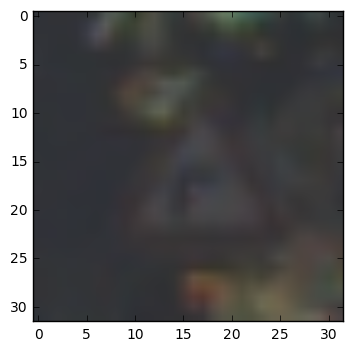

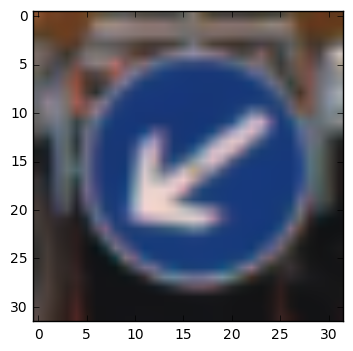

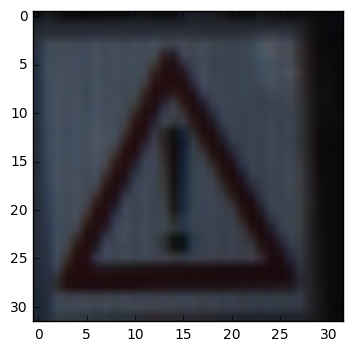

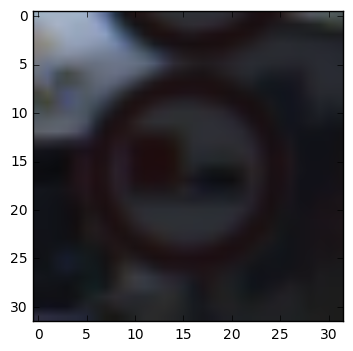

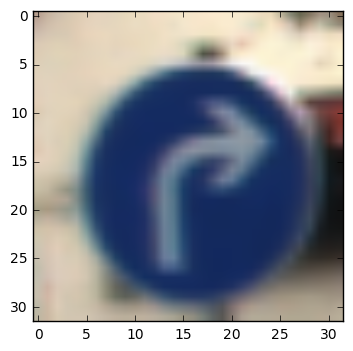

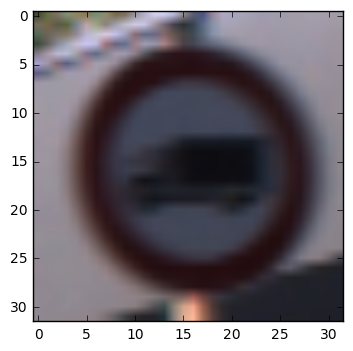

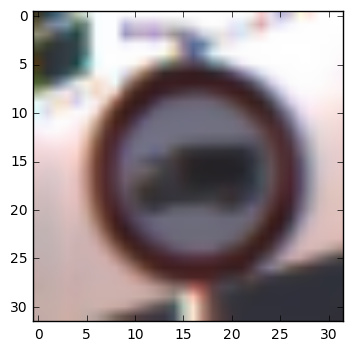

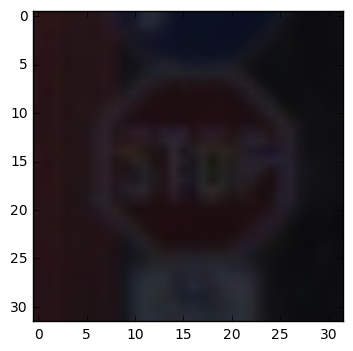

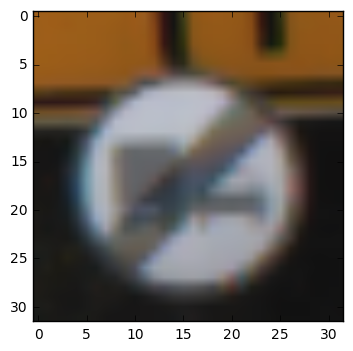

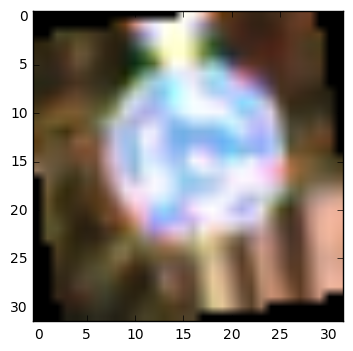

In [47]:
print_images(valid_features[0:10])

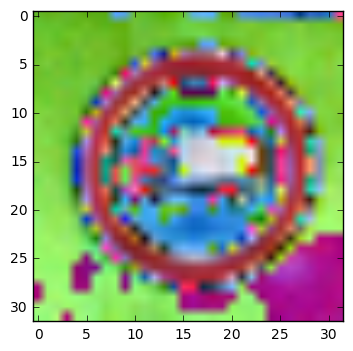

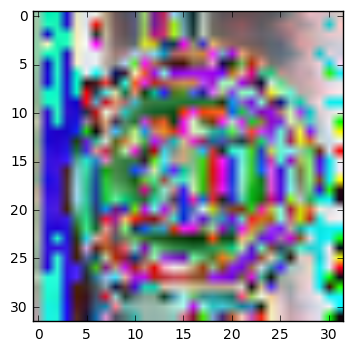

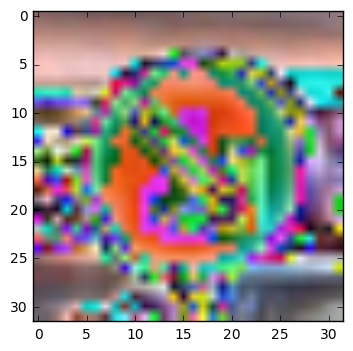

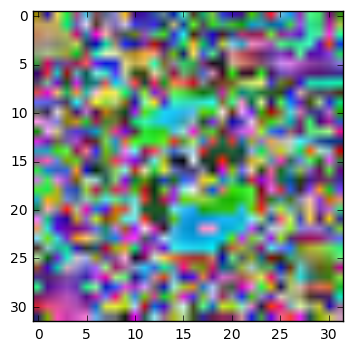

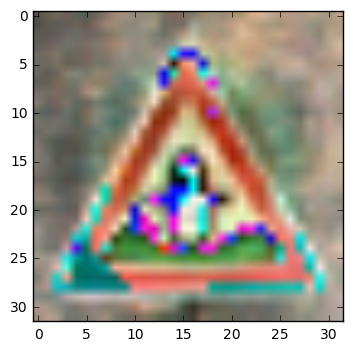

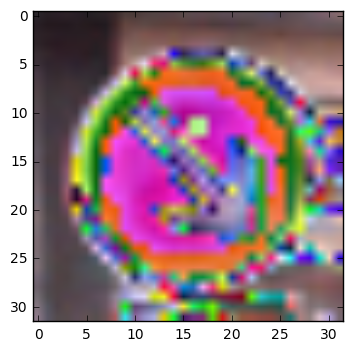

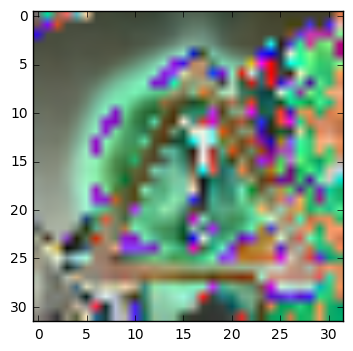

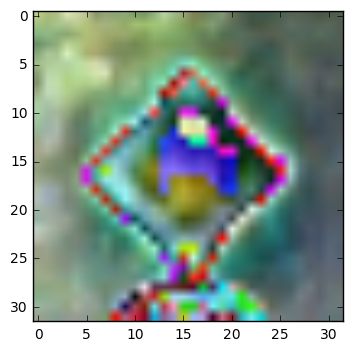

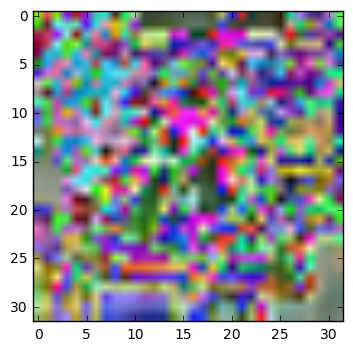

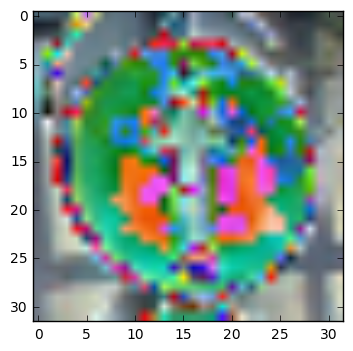

In [39]:
print_images(test_features[0:10])

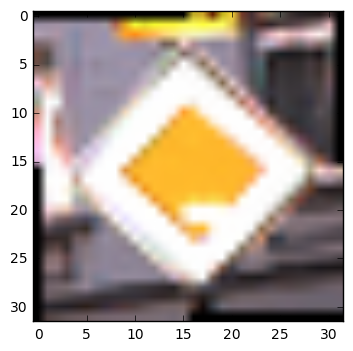

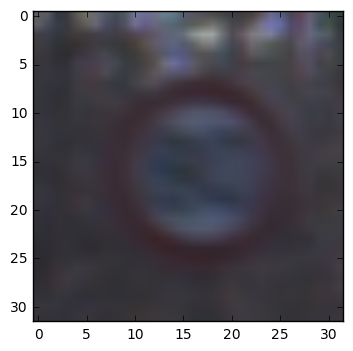

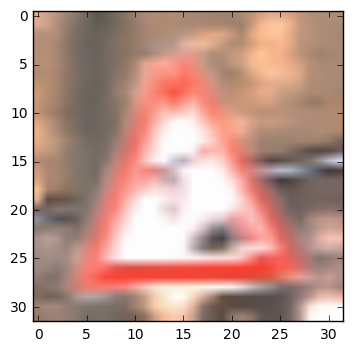

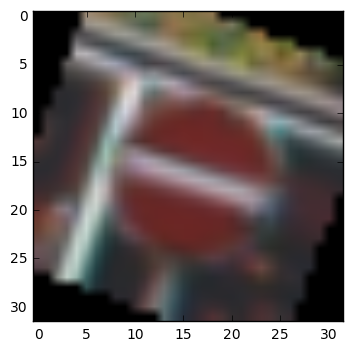

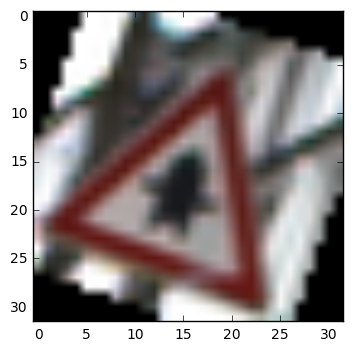

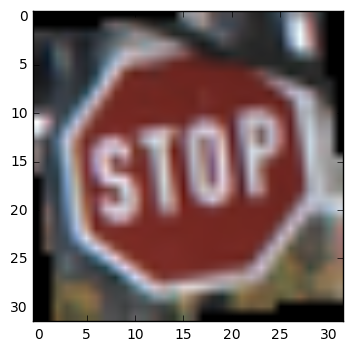

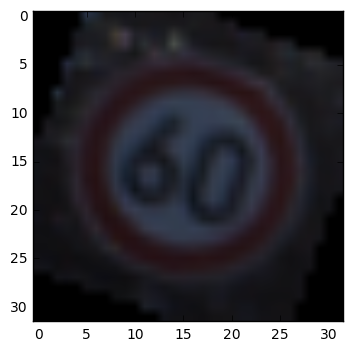

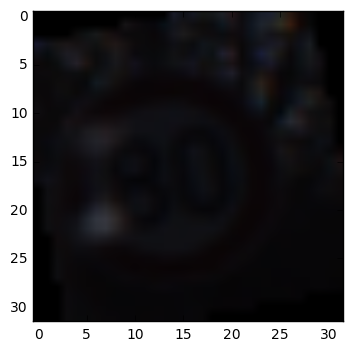

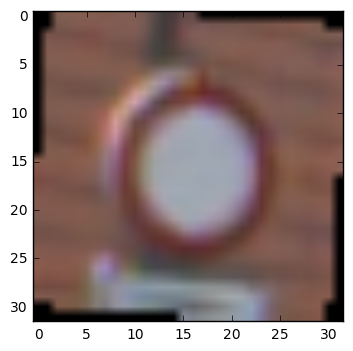

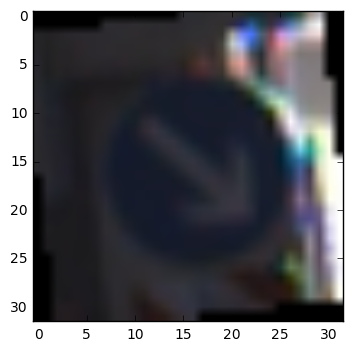

In [49]:
print_images(train_dict_features[0:10])

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [48]:
## Saves the data
data_dict = {
                'train_dataset': train_features,
                'train_labels': train_labels,
                'valid_dataset': valid_features,
                'valid_labels': valid_labels,
                'test_dataset': test_features,
                'test_labels': test_labels,
                'train_features_accuracy': train_dict_features,
                'train_labels_accuracy': train_dict_labels
            }
if grayscale:
    filename = 'traffic-signs-grayscale'
elif yuv:
    filename = 'traffic-signs-yuv'
else:
    filename = 'traffic-signs-rgb'
save_pickle(data_dict, filename)

Saving data to traffic-signs-rgb
Data saved to cache
